In [117]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re

# Load the women's clothing review dataset
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

# Filter out rows with missing review text and age
df = df.dropna(subset=['Review Text', 'Age'])

# Tokenize, remove stop words, and punctuation from review text
stop_words = set(stopwords.words('english'))
sentences_younger = []
sentences_older = []
for review, age in zip(df['Review Text'], df['Age']):
    # Tokenize and convert to lowercase
    tokens = word_tokenize(review.lower())
    # Remove punctuation and empty strings using regex
    tokens = [word for word in tokens if re.match(r'^\w+$', word)]
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    if age <= 40:
        sentences_younger.append(tokens)
    else:
        sentences_older.append(tokens)

# Train Word2Vec models for younger and older populations using different algorithms
cbow_model_younger = Word2Vec(sentences_younger, vector_size=100, window=5, min_count=1, sg=0)
print(cbow_model_younger)
sgns_model_younger = Word2Vec(sentences_younger, vector_size=100, window=5, min_count=1, sg=1)
print(sgns_model_younger)

cbow_model_older = Word2Vec(sentences_older, vector_size=100, window=5, min_count=1, sg=0)
print(cbow_model_older)
sgns_model_older = Word2Vec(sentences_older, vector_size=100, window=5, min_count=1, sg=1)
print(sgns_model_older)



Word2Vec<vocab=9967, vector_size=100, alpha=0.025>
Word2Vec<vocab=9967, vector_size=100, alpha=0.025>
Word2Vec<vocab=10379, vector_size=100, alpha=0.025>
Word2Vec<vocab=10379, vector_size=100, alpha=0.025>


In [121]:
# Define the target word
target_word = 'formal'

# Calculate cosine similarity between the target word and other words for younger population
cbow_similarities_younger = cosine_similarity([cbow_model_younger.wv[target_word]], cbow_model_younger.wv.vectors)
sgns_similarities_younger = cosine_similarity([sgns_model_younger.wv[target_word]], sgns_model_younger.wv.vectors)

# Organize the results in a tabular format for younger population
results_df_younger = pd.DataFrame({
    'Word': cbow_model_younger.wv.index_to_key,
    'CBOW Similarity (Younger)': cbow_similarities_younger.flatten(),
    'SGNS Similarity (Younger)': sgns_similarities_younger.flatten()
})

# Calculate cosine similarity between the target word and other words for older population
cbow_similarities_older = cosine_similarity([cbow_model_older.wv[target_word]], cbow_model_older.wv.vectors)
sgns_similarities_older = cosine_similarity([sgns_model_older.wv[target_word]], sgns_model_older.wv.vectors)

# Organize the results in a tabular format for older population
results_df_older = pd.DataFrame({
    'Word': cbow_model_older.wv.index_to_key,
    'CBOW Similarity (Older)': cbow_similarities_older.flatten(),
    'SGNS Similarity (Older)': sgns_similarities_older.flatten()
})

# Sort the results by similarity for younger population
results_df_younger = results_df_younger.sort_values(by=['CBOW Similarity (Younger)', 'SGNS Similarity (Younger)'], ascending=False)

# Sort the results by similarity for older population
results_df_older = results_df_older.sort_values(by=['CBOW Similarity (Older)', 'SGNS Similarity (Older)'], ascending=False)

# Display the top 10 closest words for each model for younger population
print("Top 10 closest words to 'trendy' for younger population according to CBOW model:")
print(results_df_younger[['Word', 'CBOW Similarity (Younger)']].head(11))
print("\nTop 10 closest words to 'trendy' for younger population according to SGNS model:")
print(results_df_younger[['Word', 'SGNS Similarity (Younger)']].head(11))

# Display the top 10 closest words for each model for older population
print("\nTop 10 closest words to 'trendy' for older population according to CBOW model:")
print(results_df_older[['Word', 'CBOW Similarity (Older)']].head(11))
print("\nTop 10 closest words to 'trendy' for older population according to SGNS model:")
print(results_df_older[['Word', 'SGNS Similarity (Older)']].head(11))


Top 10 closest words to 'trendy' for younger population according to CBOW model:
              Word  CBOW Similarity (Younger)
1080        formal                   1.000000
1456        events                   0.995391
458         outfit                   0.993725
1048     statement                   0.992987
1259        chunky                   0.992410
1028         scarf                   0.991058
1250       jewelry                   0.990080
677        leather                   0.990045
1098        styled                   0.989745
1884  effortlessly                   0.989380
1676       florida                   0.989308

Top 10 closest words to 'trendy' for younger population according to SGNS model:
              Word  SGNS Similarity (Younger)
1080        formal                   1.000000
1456        events                   0.937807
458         outfit                   0.907667
1048     statement                   0.954739
1259        chunky                   0.926133
1028     

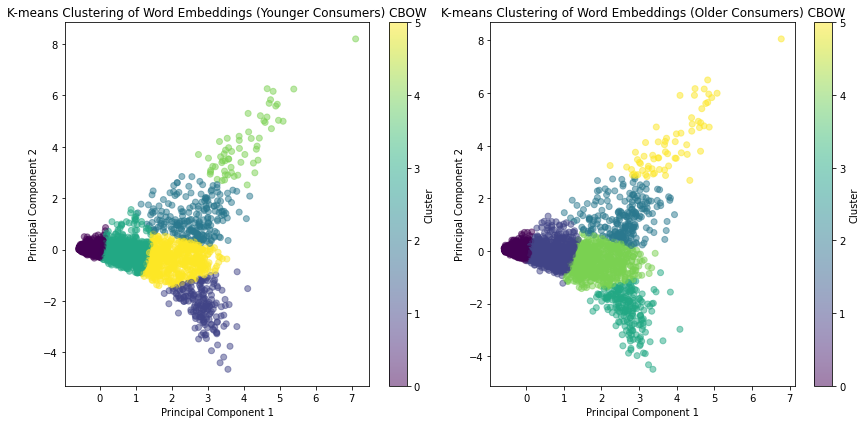

In [125]:
# Get word vectors and words for younger and older embeddings
younger_word_vectors = cbow_model_younger.wv
#younger_words = list(younger_word_vectors.index_to_key)
younger_vectors = younger_word_vectors.vectors

older_word_vectors = cbow_model_older.wv
#older_words = list(older_word_vectors.index_to_key)
older_vectors = older_word_vectors.vectors

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)

# Transform word vectors to 2D using PCA for both age groups
younger_vectors_2d = pca.fit_transform(younger_vectors)
older_vectors_2d = pca.fit_transform(older_vectors)

# Perform K-means clustering for both age groups
kmeans = KMeans(n_clusters=6)

# Cluster younger and older word vectors separately
younger_clusters = kmeans.fit_predict(younger_vectors_2d)
older_clusters = kmeans.fit_predict(older_vectors_2d)

# Visualize clusters for younger consumers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(younger_vectors_2d[:, 0], younger_vectors_2d[:, 1], c=younger_clusters, cmap='viridis', alpha=0.5)
plt.title('K-means Clustering of Word Embeddings (Younger Consumers) CBOW')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

# Visualize clusters for older consumers
plt.subplot(1, 2, 2)
plt.scatter(older_vectors_2d[:, 0], older_vectors_2d[:, 1], c=older_clusters, cmap='viridis', alpha=0.5)
plt.title('K-means Clustering of Word Embeddings (Older Consumers) CBOW')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()


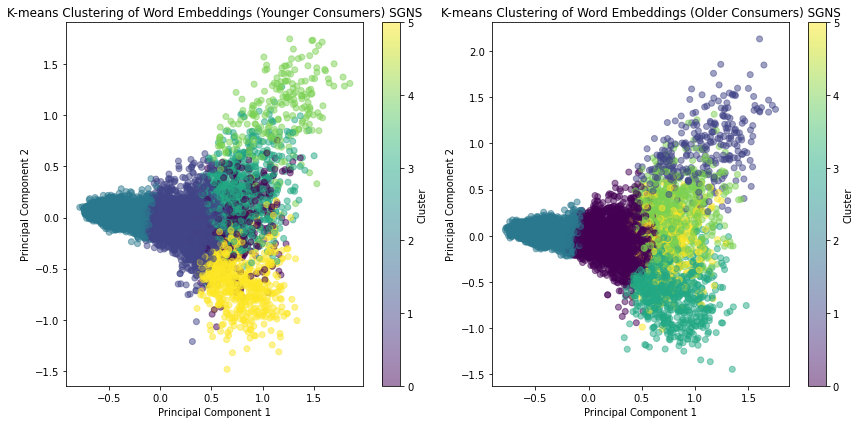

In [124]:


# Get word vectors and words for younger and older embeddings
younger_word_vectors = sgns_model_younger.wv
#younger_words = list(younger_word_vectors.index_to_key)
younger_vectors = younger_word_vectors.vectors

older_word_vectors = sgns_model_older.wv
#older_words = list(older_word_vectors.index_to_key)
older_vectors = older_word_vectors.vectors

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)

# Transform word vectors to 2D using PCA for both age groups
younger_vectors_2d = pca.fit_transform(younger_vectors)
older_vectors_2d = pca.fit_transform(older_vectors)

# Perform K-means clustering for both age groups
kmeans = KMeans(n_clusters=6)

# Cluster younger and older word vectors separately
younger_clusters = kmeans.fit_predict(younger_vectors)
older_clusters = kmeans.fit_predict(older_vectors)

# Visualize clusters for younger consumers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(younger_vectors_2d[:, 0], younger_vectors_2d[:, 1], c=younger_clusters, cmap='viridis', alpha=0.5)
plt.title('K-means Clustering of Word Embeddings (Younger Consumers) SGNS')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

# Visualize clusters for older consumers
plt.subplot(1, 2, 2)
plt.scatter(older_vectors_2d[:, 0], older_vectors_2d[:, 1], c=older_clusters, cmap='viridis', alpha=0.5)
plt.title('K-means Clustering of Word Embeddings (Older Consumers) SGNS')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()



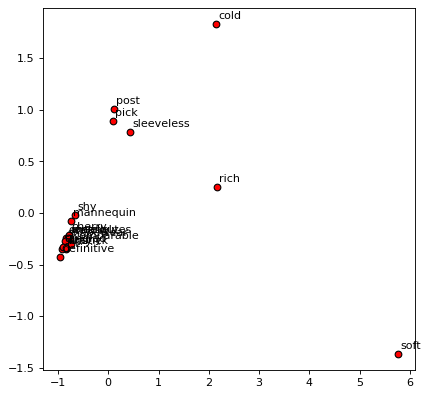

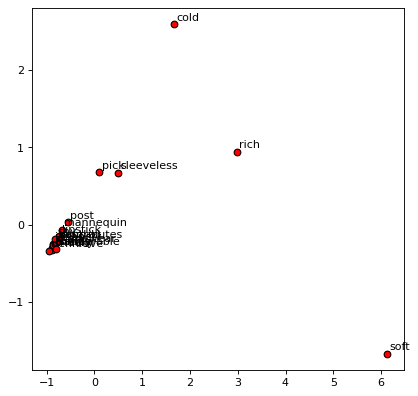

In [188]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def display_pca_scatterplot(model, words=None, sample=100, figsize=(8, 8), dpi=80):
    if words is None:
        if sample > 0:
            words = ['rich', 'cold', 'pick', 'comparable', 'contributes', 'cherry', 'insanely', 'lipstick', 'cheeky', 'mannequin', 'shapewear', 'soft', 'sleeveless', 'stray',  'tangled',  'post', 'satiny', 'definitive', 'shy']
        else:
            words = list(model.wv.index_to_key)
        
    word_vectors = np.array([model.wv[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:, :2]
    
    plt.figure(figsize=figsize, dpi=dpi)
    plt.scatter(twodim[:, 0], twodim[:, 1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, twodim):
        plt.text(x + 0.05, y + 0.05, word)
        
        

display_pca_scatterplot(cbow_model_younger, sample=10, figsize=(6, 6), dpi=80)

display_pca_scatterplot(cbow_model_older, sample=10, figsize=(6, 6), dpi=80)

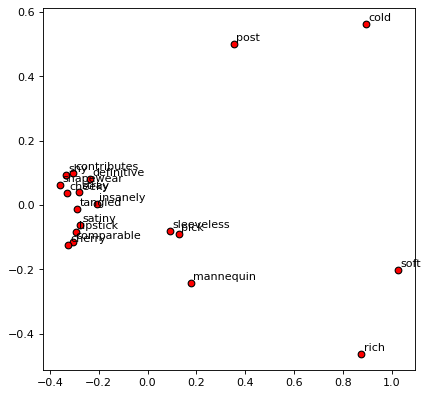

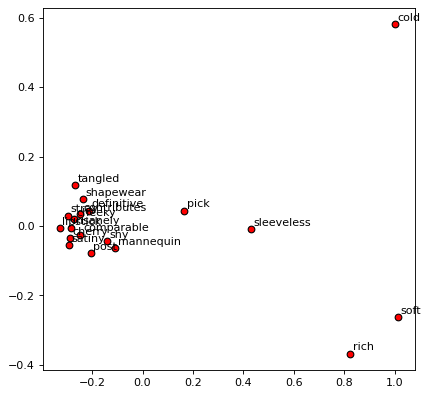

In [185]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

def display_pca_scatterplot(model, words=None, sample=100, figsize=(8, 8), dpi=80):
    if words is None:
        if sample > 0:
            words = ['rich', 'cold', 'pick', 'comparable', 'contributes', 'cherry', 'insanely', 'lipstick', 'cheeky', 'mannequin', 'shapewear', 'soft', 'sleeveless', 'stray',  'tangled',  'post', 'satiny', 'definitive', 'shy']
        else:
            words = list(model.wv.index_to_key)
        
    word_vectors = np.array([model.wv[w] for w in words])

    # Compute cosine distances
    cosine_distances = np.array([[1 - cosine(vec1, vec2) for vec2 in word_vectors] for vec1 in word_vectors])

    # Perform PCA using cosine distances
    twodim = PCA().fit_transform(cosine_distances)[:, :2]
    
    plt.figure(figsize=figsize, dpi=dpi)
    plt.scatter(twodim[:, 0], twodim[:, 1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, twodim):
        plt.text(x + 0.01, y + 0.01, word)

display_pca_scatterplot(sgns_model_younger, sample=10, figsize=(6, 6), dpi=80)

display_pca_scatterplot(sgns_model_older, sample=10, figsize=(6, 6), dpi=80)


In [107]:
reviews_containing_death = df[df['Review Text'].str.contains('death', case=False, na=False)]

# Display the filtered reviews
list = reviews_containing_death[['Review Text']]

review_list = reviews_containing_death['Review Text'].tolist()

# Print the first item in the list
print(review_list[2])

This gem is beyond lovely! i saw this 5 years ago and regretted not buying it 5 years ago and then i was looking on here as i do on a weekly basis and bam it was there, i gasped hahahaha but really this is an amazing statement piece. i am usually a l but got the m as it is a bit big and its your preference on how you want to wear it. i will be wearing this to death for autumn winter and forever its just one of those. soft and not itchy and i have sensitive skin.


In [102]:
print(df.iloc[718])

Unnamed: 0                                                               754
Clothing ID                                                             1087
Age                                                                       62
Title                                                 Perfer beige over pink
Review Text                I had tried this on in the beige & loved it bu...
Rating                                                                     3
Recommended IND                                                            0
Positive Feedback Count                                                    0
Division Name                                                        General
Department Name                                                      Dresses
Class Name                                                           Dresses
Name: 754, dtype: object


In [167]:
# Define the target word
target_word = 'retro'

# Calculate cosine similarity between the target word and other words for younger population
cbow_similarities_younger = cosine_similarity([cbow_model_younger.wv[target_word]], cbow_model_younger.wv.vectors)
sgns_similarities_younger = cosine_similarity([sgns_model_younger.wv[target_word]], sgns_model_younger.wv.vectors)

# Organize the results in a tabular format for younger population
results_df_younger = pd.DataFrame({
    'Word': cbow_model_younger.wv.index_to_key,
    'CBOW Similarity (Younger)': cbow_similarities_younger.flatten(),
    'SGNS Similarity (Younger)': sgns_similarities_younger.flatten()
})

# Calculate cosine similarity between the target word and other words for older population
cbow_similarities_older = cosine_similarity([cbow_model_older.wv[target_word]], cbow_model_older.wv.vectors)
sgns_similarities_older = cosine_similarity([sgns_model_older.wv[target_word]], sgns_model_older.wv.vectors)

# Organize the results in a tabular format for older population
results_df_older = pd.DataFrame({
    'Word': cbow_model_older.wv.index_to_key,
    'CBOW Similarity (Older)': cbow_similarities_older.flatten(),
    'SGNS Similarity (Older)': sgns_similarities_older.flatten()
})

# Sort the results by similarity for younger population
results_df_younger_cbow_top10 = results_df_younger.sort_values(by='CBOW Similarity (Younger)', ascending=False).head(11)
results_df_younger_sgns_top10 = results_df_younger.sort_values(by='SGNS Similarity (Younger)', ascending=False).head(11)

# Sort the results by similarity for older population
results_df_older_cbow_top10 = results_df_older.sort_values(by='CBOW Similarity (Older)', ascending=False).head(11)
results_df_older_sgns_top10 = results_df_older.sort_values(by='SGNS Similarity (Older)', ascending=False).head(11)



# Display the top 10 closest words for each model for younger population
print("Top 10 closest words to " + str(target_word)+ " for younger population according to CBOW model:")
print(results_df_younger_cbow_top10[['Word', 'CBOW Similarity (Younger)']].head(11))
print("\nTop 10 closest words to " + str(target_word)+ " for younger population according to SGNS model:")
print(results_df_younger_sgns_top10[['Word', 'SGNS Similarity (Younger)']].head(11))

# Display the top 10 closest words for each model for older population
print("\nTop 10 closest words to " + str(target_word)+ " for older population according to CBOW model:")
print(results_df_older_cbow_top10[['Word', 'CBOW Similarity (Older)']].head(11))
print("\nTop 10 closest words to " + str(target_word)+ " for older population according to SGNS model:")
print(results_df_older_sgns_top10[['Word', 'SGNS Similarity (Older)']].head(11))


Top 10 closest words to retro for younger population according to CBOW model:
              Word  CBOW Similarity (Younger)
1533         retro                   1.000000
1508      stitched                   0.990909
1493       darling                   0.990479
785        styling                   0.988961
1369          cons                   0.988245
2301         sleek                   0.987430
856             oh                   0.987410
2385       crooked                   0.987211
789   surprisingly                   0.987065
1790        nature                   0.986972
1378        modern                   0.986854

Top 10 closest words to retro for younger population according to SGNS model:
           Word  SGNS Similarity (Younger)
1533      retro                   1.000000
1378     modern                   0.970578
1911      soooo                   0.962703
1461    shimmer                   0.961465
2178     brings                   0.958449
1376  luxurious                  

In [175]:
import random

# Define a function to select random words from a model
def random_words_from_model(model, num_words=20):
    # Get the vocabulary from the model
    vocab = model.wv.index_to_key
    
    # Select random words from the vocabulary
    random_words = random.sample(vocab, num_words)
    
    return random_words

# Select random words from the CBOW model for the younger population
random_words_cbow_younger = random_words_from_model(cbow_model_younger)

# Select random words from the CBOW model for the older population
random_words_cbow_older = random_words_from_model(cbow_model_older)

# Select random words from the SGNS model for the younger population
random_words_sgns_younger = random_words_from_model(sgns_model_younger)

# Select random words from the SGNS model for the older population
random_words_sgns_older = random_words_from_model(sgns_model_older)

# Display the randomly selected words
print("Random words from CBOW model for younger population:", random_words_cbow_younger)
print("\nRandom words from CBOW model for older population:", random_words_cbow_older)
print("\nRandom words from SGNS model for younger population:", random_words_sgns_younger)
print("\nRandom words from SGNS model for older population:", random_words_sgns_older)



Random words from CBOW model for younger population: ['carefully', 'xspetite', 'shows', 'hunched', 'dreses', 'exquisitely', 'continuous', 'desperat', 'selected', 'february', 'grayish', 'waht', 'colour', 'write', 'tubes', 'steaming', 'lacking', 'northwest', 'tween', 'compl']

Random words from CBOW model for older population: ['clincher', '4r', 'peekaboo', '18', 'phd', 'bermuda', 'blouses', 'heals', 'tigh', 'peroxide', 'saldly', 'recieved', 'immediatley', 'kaftan', 'collarbone', 'decolletage', '1970s', 'lily', 'underlayment', 'buyer']

Random words from SGNS model for younger population: ['fluffier', 'info', 'fullest', 'regretted', 'crushed', 'scarves', 'low', 'ab', 'topper', 'rain', 'sinclair', 'lucky', 'solely', 'happening', 'reservations', 'stra', 'wrist', 'terracotta', 'ethereal', 'unsewn']

Random words from SGNS model for older population: ['rich', 'comparable', 'contributes', 'cherry', 'insanely', 'lipstick', 'cheeky', 'mannequin', 'frabic', 'shapewear', 'soft', 'sleeveless', 'st